In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [22]:
cardioRaw=pd.read_parquet('./cardio.parquet')

Age | Objective Feature | age | int (days)

Height | Objective Feature | height | int (cm) |

Weight | Objective Feature | weight | float (kg) |

Gender | Objective Feature | gender | categorical code |

Systolic blood pressure | Examination Feature | ap_hi | int |

Diastolic blood pressure | Examination Feature | ap_lo | int |

Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

Smoking | Subjective Feature | smoke | binary |

Alcohol intake | Subjective Feature | alco | binary |

Physical activity | Subjective Feature | active | binary |

Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


In [23]:
# Explore dataset structure
print("Dataset shape:", cardioRaw.shape)
cardioRaw.head()


Dataset shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [24]:
# Check for missing values
print("Missing values:")
print(cardioRaw.isnull().sum())


Missing values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [25]:
# Check data types
print("Data types:")
print(cardioRaw.dtypes)


Data types:
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


In [26]:
# Basic statistics
cardioRaw.drop('id', axis=1, inplace=True)
cardioRaw.describe()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


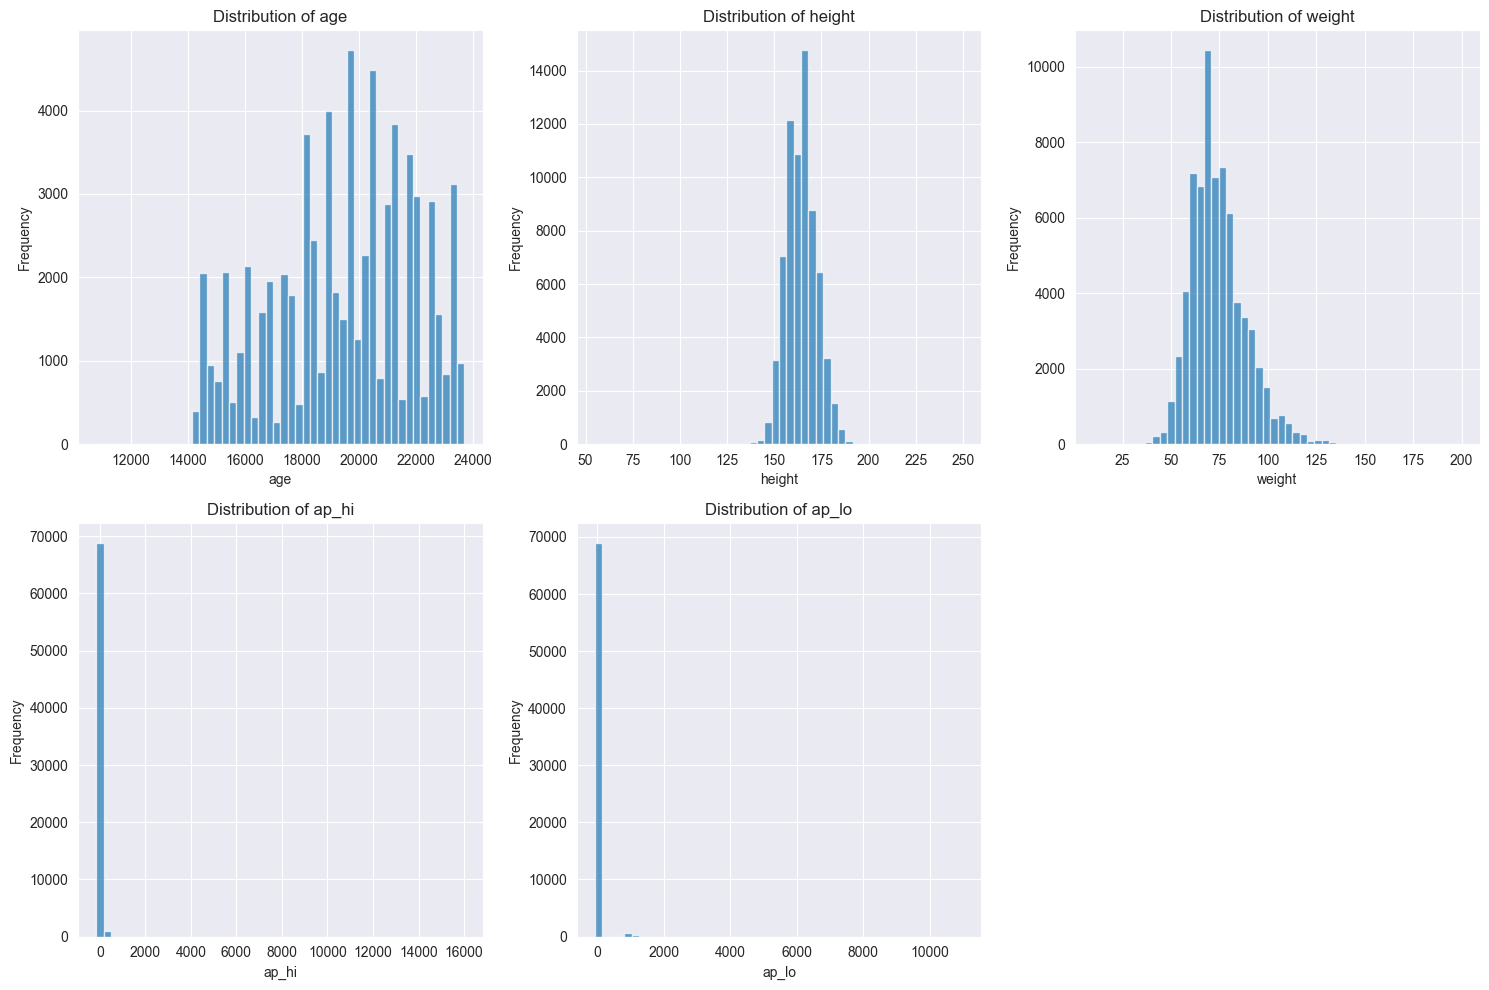

In [27]:
# Check the distribution of numerical features
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    axes[i].hist(cardioRaw[feature], bins=50, alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove the empty subplot
axes[5].remove()
plt.tight_layout()
plt.show()


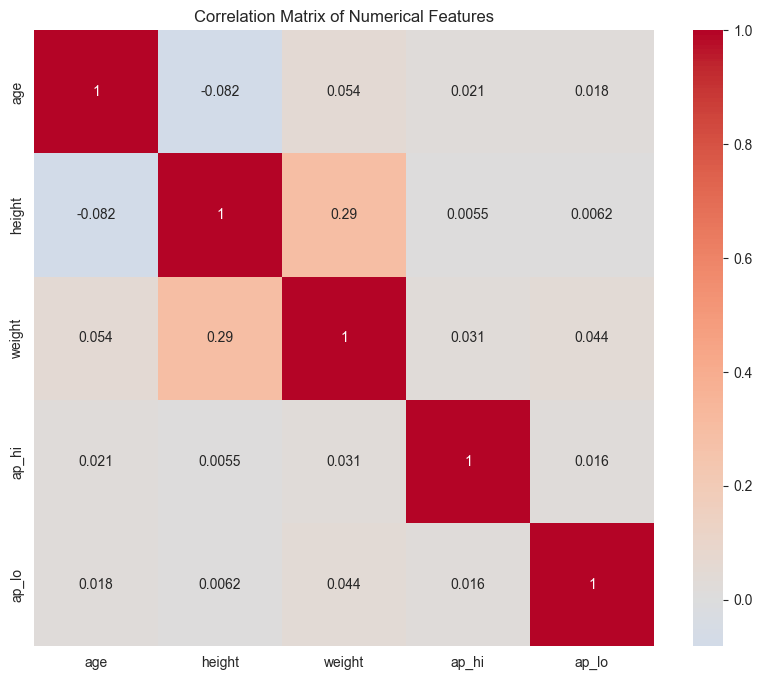

In [28]:
# Analyze correlations between numerical features
correlation_matrix = cardioRaw[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


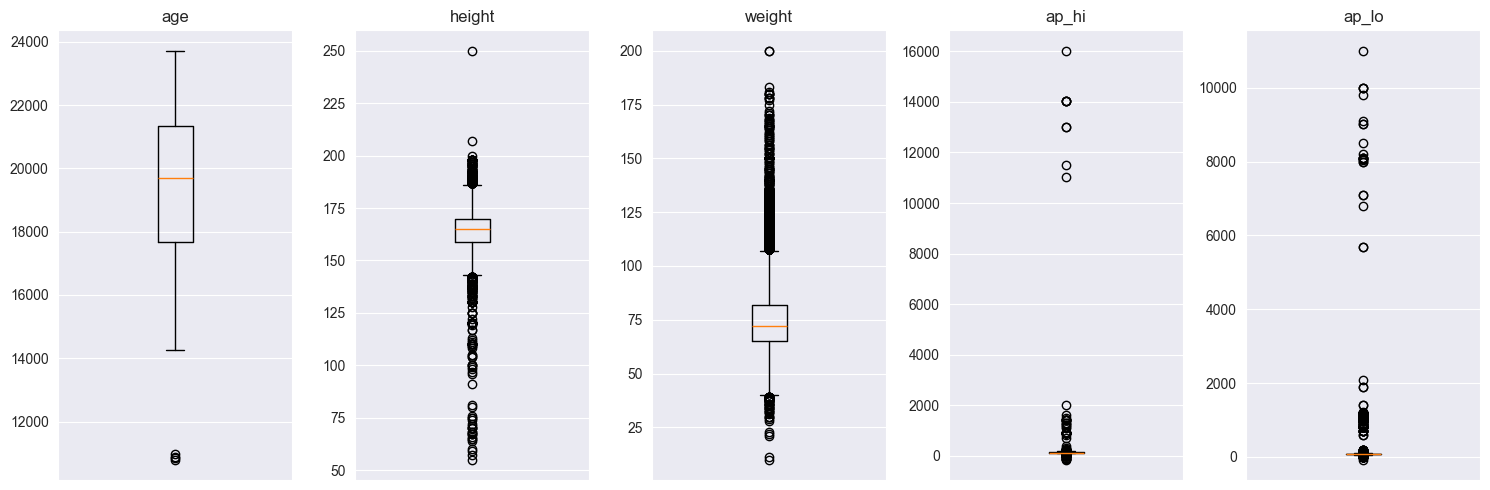

In [29]:
# Check for outliers in numerical features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 5, i+1)
    plt.boxplot(cardioRaw[feature])
    plt.title(f'{feature}')
    plt.xticks([])
plt.tight_layout()
plt.show()


In [30]:
# Calculate BMI as a potential derived numerical target
cardioRaw['bmi'] = cardioRaw['weight'] / ((cardioRaw['height'] / 100) ** 2)

print("BMI Analysis:")
print(f"BMI Range: {cardioRaw['bmi'].min():.2f} - {cardioRaw['bmi'].max():.2f}")
print(f"BMI Mean: {cardioRaw['bmi'].mean():.2f}")
print(f"BMI Std: {cardioRaw['bmi'].std():.2f}")

# BMI categories
print("\nBMI Categories:")
print(f"Underweight (<18.5): {(cardioRaw['bmi'] < 18.5).sum()}")
print(f"Normal (18.5-24.9): {((cardioRaw['bmi'] >= 18.5) & (cardioRaw['bmi'] < 25)).sum()}")
print(f"Overweight (25-29.9): {((cardioRaw['bmi'] >= 25) & (cardioRaw['bmi'] < 30)).sum()}")
print(f"Obese (≥30): {(cardioRaw['bmi'] >= 30).sum()}")


BMI Analysis:
BMI Range: 3.47 - 298.67
BMI Mean: 27.56
BMI Std: 6.09

BMI Categories:
Underweight (<18.5): 650
Normal (18.5-24.9): 25790
Overweight (25-29.9): 25086
Obese (≥30): 18474


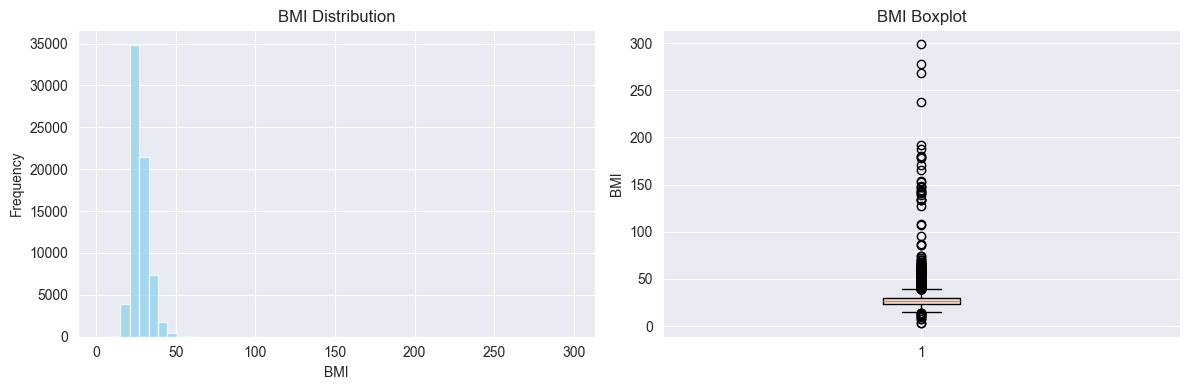

In [31]:
# Visualize BMI distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(cardioRaw['bmi'], bins=50, alpha=0.7, color='skyblue')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(cardioRaw['bmi'])
plt.title('BMI Boxplot')
plt.ylabel('BMI')

plt.tight_layout()
plt.show()


In [32]:
# Recommended numerical target variable selection
print("="*60)
print("RECOMMENDATION FOR NUMERICAL TARGET VARIABLE")
print("="*60)
print("\nBased on the analysis, here are the best options for numerical target variables:")
print("\n1. SYSTOLIC BLOOD PRESSURE (ap_hi) - RECOMMENDED")
print("   ✓ Continuous numerical variable")
print("   ✓ Clinical significance")
print("   ✓ Good range of values for regression")
print("   ✓ Related to cardiovascular health")
print("   ✓ Medically interpretable results")

print("\n2. BMI (derived from height/weight) - ALTERNATIVE")
print("   ✓ Continuous numerical variable")
print("   ✓ Health-related target")
print("   ✓ Well-understood medical metric")
print("   ✓ Good for demonstrating feature engineering")

print("\n3. DIASTOLIC BLOOD PRESSURE (ap_lo) - ALTERNATIVE")
print("   ✓ Continuous numerical variable")
print("   ✓ Clinical significance")
print("   ✓ Complementary to systolic pressure")

print("\n" + "="*60)
print("SELECTED TARGET: SYSTOLIC BLOOD PRESSURE (ap_hi)")
print("="*60)


RECOMMENDATION FOR NUMERICAL TARGET VARIABLE

Based on the analysis, here are the best options for numerical target variables:

1. SYSTOLIC BLOOD PRESSURE (ap_hi) - RECOMMENDED
   ✓ Continuous numerical variable
   ✓ Clinical significance
   ✓ Good range of values for regression
   ✓ Related to cardiovascular health
   ✓ Medically interpretable results

2. BMI (derived from height/weight) - ALTERNATIVE
   ✓ Continuous numerical variable
   ✓ Health-related target
   ✓ Well-understood medical metric
   ✓ Good for demonstrating feature engineering

3. DIASTOLIC BLOOD PRESSURE (ap_lo) - ALTERNATIVE
   ✓ Continuous numerical variable
   ✓ Clinical significance
   ✓ Complementary to systolic pressure

SELECTED TARGET: SYSTOLIC BLOOD PRESSURE (ap_hi)


In [33]:
# Data cleaning for the selected target variable (ap_hi)
print("Data cleaning for systolic blood pressure (ap_hi):")

# Check for unrealistic values
print(f"Original data points: {len(cardioRaw)}")
print(f"ap_hi range: {cardioRaw['ap_hi'].min()} - {cardioRaw['ap_hi'].max()}")

# Remove unrealistic blood pressure values (outside physiologically possible range)
# Systolic BP should be between 70-250 mmHg for alive individuals
cardio_cleaned = cardioRaw[(cardioRaw['ap_hi'] >= 70) & (cardioRaw['ap_hi'] <= 250)].copy()
print(f"After removing unrealistic ap_hi values: {len(cardio_cleaned)}")

# Also clean diastolic pressure for consistency
cardio_cleaned = cardio_cleaned[(cardio_cleaned['ap_lo'] >= 40) & (cardio_cleaned['ap_lo'] <= 150)]
print(f"After removing unrealistic ap_lo values: {len(cardio_cleaned)}")

# Ensure systolic > diastolic
cardio_cleaned = cardio_cleaned[cardio_cleaned['ap_hi'] > cardio_cleaned['ap_lo']]
print(f"After ensuring ap_hi > ap_lo: {len(cardio_cleaned)}")

print(f"\nFinal cleaned dataset size: {len(cardio_cleaned)}")
print(f"Removed {len(cardioRaw) - len(cardio_cleaned)} rows ({((len(cardioRaw) - len(cardio_cleaned))/len(cardioRaw)*100):.2f}%)")


Data cleaning for systolic blood pressure (ap_hi):
Original data points: 70000
ap_hi range: -150 - 16020
After removing unrealistic ap_hi values: 69771
After removing unrealistic ap_lo values: 68754
After ensuring ap_hi > ap_lo: 68666

Final cleaned dataset size: 68666
Removed 1334 rows (1.91%)


In [34]:
# Final dataset summary with ap_hi as target
print("FINAL DATASET SUMMARY")
print("="*40)
print(f"Target Variable: ap_hi (Systolic Blood Pressure)")
print(f"Dataset size: {len(cardio_cleaned)} samples")
print(f"Features: {len(cardio_cleaned.columns) - 1}")
print(f"Target range: {cardio_cleaned['ap_hi'].min()} - {cardio_cleaned['ap_hi'].max()}")
print(f"Target mean: {cardio_cleaned['ap_hi'].mean():.2f}")
print(f"Target std: {cardio_cleaned['ap_hi'].std():.2f}")

# Display final cleaned dataset
cardio_cleaned.head()


FINAL DATASET SUMMARY
Target Variable: ap_hi (Systolic Blood Pressure)
Dataset size: 68666 samples
Features: 12
Target range: 70 - 240
Target mean: 126.67
Target std: 16.68


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [35]:
# STEP 1: Delete null values and prepare data with ap_hi as target
print("STEP 1: Data Cleaning and Target Selection")
print("="*50)

# Use the cleaned dataset from previous analysis
target_data = cardio_cleaned.copy()

# Check for null values
print("Null values check:")
print(target_data.isnull().sum())

# Remove any remaining null values
target_data = target_data.dropna()
print(f"Dataset size after removing nulls: {len(target_data)}")

# Set ap_hi as target variable and remove cardio (original binary target)
y = target_data['ap_hi'].copy()
X = target_data.drop(['ap_hi', 'cardio'], axis=1)

print(f"Target variable (ap_hi) shape: {y.shape}")
print(f"Features shape: {X.shape}")
print(f"Feature columns: {X.columns.tolist()}")


STEP 1: Data Cleaning and Target Selection
Null values check:
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
bmi            0
dtype: int64
Dataset size after removing nulls: 68666
Target variable (ap_hi) shape: (68666,)
Features shape: (68666, 11)
Feature columns: ['age', 'gender', 'height', 'weight', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']


In [36]:
# STEP 2: Create interaction features
print("\nSTEP 2: Feature Engineering - Creating Interaction Features")
print("="*50)

# Convert age from days to years for better interpretability
X['age_years'] = X['age'] / 365.25

# Create BMI if not already present
if 'bmi' not in X.columns:
    X['bmi'] = X['weight'] / ((X['height'] / 100) ** 2)

# Create interaction features that make medical sense
print("Creating interaction features...")

# Age-related interactions
X['age_weight_interaction'] = X['age_years'] * X['weight']
X['age_bmi_interaction'] = X['age_years'] * X['bmi']

# Blood pressure related interactions
X['blood_pressure_diff'] = X['ap_hi'] - X['ap_lo'] if 'ap_hi' in X.columns else X['ap_lo']  # This will be ap_lo since we removed ap_hi
X['pulse_pressure'] = X['blood_pressure_diff']  # Rename for clarity

# Health risk interactions
X['cholesterol_glucose_interaction'] = X['cholesterol'] * X['gluc']
X['lifestyle_risk'] = X['smoke'] + X['alco'] - X['active']  # Higher = more risk

# Physical characteristics
X['height_weight_ratio'] = X['height'] / X['weight']
X['weight_height_interaction'] = X['weight'] * X['height']

# Age and lifestyle interactions
X['age_smoke_interaction'] = X['age_years'] * X['smoke']
X['age_alcohol_interaction'] = X['age_years'] * X['alco']

print(f"Features after interaction creation: {X.shape[1]}")
print("New interaction features created:")
interaction_features = ['age_years', 'bmi', 'age_weight_interaction', 'age_bmi_interaction',
                       'pulse_pressure', 'cholesterol_glucose_interaction', 'lifestyle_risk',
                       'height_weight_ratio', 'weight_height_interaction', 'age_smoke_interaction',
                       'age_alcohol_interaction']
for feat in interaction_features:
    if feat in X.columns:
        print(f"  - {feat}")



STEP 2: Feature Engineering - Creating Interaction Features
Creating interaction features...
Features after interaction creation: 22
New interaction features created:
  - age_years
  - bmi
  - age_weight_interaction
  - age_bmi_interaction
  - pulse_pressure
  - cholesterol_glucose_interaction
  - lifestyle_risk
  - height_weight_ratio
  - weight_height_interaction
  - age_smoke_interaction
  - age_alcohol_interaction


In [37]:
# STEP 3: Identify and prepare categorical/binary features for encoding
print("\nSTEP 3: Identifying Features for Encoding")
print("="*50)

# Identify binary and categorical columns
binary_columns = ['gender', 'smoke', 'alco', 'active']
categorical_columns = ['cholesterol', 'gluc']  # These are ordinal but we'll treat as categorical
numerical_columns = [col for col in X.columns if col not in binary_columns + categorical_columns]

print(f"Binary columns for one-hot encoding: {binary_columns}")
print(f"Categorical columns for one-hot encoding: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

# Check unique values in categorical columns
for col in categorical_columns:
    print(f"{col} unique values: {sorted(X[col].unique())}")



STEP 3: Identifying Features for Encoding
Binary columns for one-hot encoding: ['gender', 'smoke', 'alco', 'active']
Categorical columns for one-hot encoding: ['cholesterol', 'gluc']
Numerical columns: ['age', 'height', 'weight', 'ap_lo', 'bmi', 'age_years', 'age_weight_interaction', 'age_bmi_interaction', 'blood_pressure_diff', 'pulse_pressure', 'cholesterol_glucose_interaction', 'lifestyle_risk', 'height_weight_ratio', 'weight_height_interaction', 'age_smoke_interaction', 'age_alcohol_interaction']
cholesterol unique values: [np.int64(1), np.int64(2), np.int64(3)]
gluc unique values: [np.int64(1), np.int64(2), np.int64(3)]


In [38]:
# STEP 4: Create preprocessing pipeline and fit_transform
print("\nSTEP 4: Data Preprocessing Pipeline")
print("="*50)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns),
        ('bin', OneHotEncoder(drop='first', sparse_output=False), binary_columns)
    ],
    remainder='passthrough'
)

# Fit and transform the data
print("Fitting and transforming features...")
X_transformed = preprocessor.fit_transform(X)

# Get feature names after transformation
feature_names = []
# Numerical features
feature_names.extend(numerical_columns)
# Categorical features
for i, col in enumerate(categorical_columns):
    encoder = preprocessor.named_transformers_['cat']
    if hasattr(encoder, 'categories_'):
        categories = encoder.categories_[i]
        feature_names.extend([f"{col}_{cat}" for cat in categories[1:]])  # Skip first due to drop='first'
# Binary features
for i, col in enumerate(binary_columns):
    encoder = preprocessor.named_transformers_['bin']
    if hasattr(encoder, 'categories_'):
        categories = encoder.categories_[i]
        feature_names.extend([f"{col}_{cat}" for cat in categories[1:]])  # Skip first due to drop='first'

print(f"Final feature count after preprocessing: {X_transformed.shape[1]}")
print(f"Final dataset shape: {X_transformed.shape}")



STEP 4: Data Preprocessing Pipeline
Fitting and transforming features...
Final feature count after preprocessing: 24
Final dataset shape: (68666, 24)


In [39]:
# STEP 5: Additional preprocessing for XGBoost
print("\nSTEP 5: Additional Preprocessing for XGBoost")
print("="*50)

# XGBoost specific considerations
print("XGBoost preprocessing considerations:")
print("✓ Handle missing values: Already done")
print("✓ Feature scaling: Applied StandardScaler to numerical features")
print("✓ Categorical encoding: Applied OneHotEncoder")
print("✓ Feature interactions: Created relevant medical interactions")

# Check for any infinite or extremely large values
import numpy as np
inf_mask = np.isinf(X_transformed).any(axis=1)
if inf_mask.sum() > 0:
    print(f"Removing {inf_mask.sum()} rows with infinite values")
    X_transformed = X_transformed[~inf_mask]
    y = y[~inf_mask]

# Check target variable distribution
print(f"\nTarget variable (ap_hi) statistics:")
print(f"Mean: {y.mean():.2f}")
print(f"Std: {y.std():.2f}")
print(f"Min: {y.min()}")
print(f"Max: {y.max()}")
print(f"Range: {y.max() - y.min()}")

# Check for outliers in target variable (optional log transformation consideration)
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
outliers = ((y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))).sum()
print(f"Target outliers (IQR method): {outliers} ({outliers/len(y)*100:.2f}%)")



STEP 5: Additional Preprocessing for XGBoost
XGBoost preprocessing considerations:
✓ Handle missing values: Already done
✓ Feature scaling: Applied StandardScaler to numerical features
✓ Categorical encoding: Applied OneHotEncoder
✓ Feature interactions: Created relevant medical interactions

Target variable (ap_hi) statistics:
Mean: 126.67
Std: 16.68
Min: 70
Max: 240
Range: 170
Target outliers (IQR method): 1005 (1.46%)


In [40]:
# STEP 6: Train-Test Split and Save as Parquet
print("\nSTEP 6: Train-Test Split and Saving Data")
print("="*50)

from sklearn.model_selection import train_test_split

# Split into 90% train, 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y,
    test_size=0.1,
    random_state=42,
    stratify=None  # Can't stratify continuous target
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set percentage: {X_train.shape[0]/len(X_transformed)*100:.1f}%")
print(f"Test set percentage: {X_test.shape[0]/len(X_transformed)*100:.1f}%")

# Convert to DataFrames for easier saving
train_features_df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
test_features_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
train_target_df = pd.DataFrame(y_train.values, columns=['ap_hi'])
test_target_df = pd.DataFrame(y_test.values, columns=['ap_hi'])

# Save as parquet files
print("\nSaving preprocessed data as parquet files...")
train_features_df.to_parquet('X_train.parquet', index=False)
test_features_df.to_parquet('X_test.parquet', index=False)
train_target_df.to_parquet('y_train.parquet', index=False)
test_target_df.to_parquet('y_test.parquet', index=False)

print("✓ X_train.parquet saved")
print("✓ X_test.parquet saved")
print("✓ y_train.parquet saved")
print("✓ y_test.parquet saved")



STEP 6: Train-Test Split and Saving Data
Training set size: 61799 samples
Test set size: 6867 samples
Training set percentage: 90.0%
Test set percentage: 10.0%

Saving preprocessed data as parquet files...
✓ X_train.parquet saved
✓ X_test.parquet saved
✓ y_train.parquet saved
✓ y_test.parquet saved


In [41]:
# STEP 7: Summary and Feature Importance Preparation
print("\nSTEP 7: Final Summary and Feature Information")
print("="*50)

# Save feature names and preprocessing info for future reference
feature_info = {
    'feature_names': feature_names if len(feature_names) == X_transformed.shape[1] else [f'feature_{i}' for i in range(X_transformed.shape[1])],
    'numerical_features': numerical_columns,
    'categorical_features': categorical_columns,
    'binary_features': binary_columns,
    'interaction_features': interaction_features,
    'target_variable': 'ap_hi',
    'train_size': X_train.shape[0],
    'test_size': X_test.shape[0],
    'total_features': X_transformed.shape[1]
}

# Save feature info
import pickle
with open('feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

print("PREPROCESSING COMPLETE!")
print("="*50)
print(f"✓ Target variable: ap_hi (Systolic Blood Pressure)")
print(f"✓ Dataset cleaned and preprocessed")
print(f"✓ {len(interaction_features)} interaction features created")
print(f"✓ Categorical and binary features one-hot encoded")
print(f"✓ Numerical features standardized")
print(f"✓ Train-test split: 90%-10%")
print(f"✓ Data saved as parquet files")
print(f"✓ Ready for XGBoost regression!")

print(f"\nFinal dataset statistics:")
print(f"  - Training samples: {X_train.shape[0]}")
print(f"  - Test samples: {X_test.shape[0]}")
print(f"  - Total features: {X_transformed.shape[1]}")
print(f"  - Target range: {y.min():.0f} - {y.max():.0f} mmHg")
print(f"  - Target mean: {y.mean():.1f} ± {y.std():.1f} mmHg")

# Display sample of final processed data
print(f"\nSample of preprocessed training data:")
sample_df = pd.DataFrame(X_train[:5], columns=[f'feature_{i}' for i in range(X_train.shape[1])])
sample_df['target_ap_hi'] = y_train.iloc[:5].values
print(sample_df)



STEP 7: Final Summary and Feature Information
PREPROCESSING COMPLETE!
✓ Target variable: ap_hi (Systolic Blood Pressure)
✓ Dataset cleaned and preprocessed
✓ 11 interaction features created
✓ Categorical and binary features one-hot encoded
✓ Numerical features standardized
✓ Train-test split: 90%-10%
✓ Data saved as parquet files
✓ Ready for XGBoost regression!

Final dataset statistics:
  - Training samples: 61799
  - Test samples: 6867
  - Total features: 24
  - Target range: 70 - 240 mmHg
  - Target mean: 126.7 ± 16.7 mmHg

Sample of preprocessed training data:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.503844   0.566861  -0.287328  -2.260614  -0.497790  -0.503844   
1   0.109569  -0.410683   1.945448  -0.138120   1.954593   0.109569   
2   1.015508   0.078089  -0.287328  -0.138120  -0.299054   1.015508   
3  -1.059319   0.322475   1.177931  -0.138120   0.844022  -1.059319   
4   1.516692   0.444668  -0.287328   0.923127  -0.449434   1.516692   

 